<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Gerais/blob/main/TG_Previs%C3%A3o_de_carga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import date

import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
hoje = date.today()
hoje = str(hoje)

In [ ]:
baseDIR = "/content/drive/MyDrive/TG/DADOS SUDESTE"

In [ ]:
historicoCarga = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperatura = pd.read_csv(os.path.join(baseDIR,'SECO_2021-01-27_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
historico = historicoCarga.merge(historicoTemperatura)
historico = historico.drop(["Min"], axis = 1 )
historico

,Ano,Mes,Dia,Hora,Carga,Temperatura
0,2014,1,1,1,31681.2,24.648
1,2014,1,1,2,31475.9,24.530
2,2014,1,1,3,30848.3,23.857
3,2014,1,1,4,29885.6,23.857
4,2014,1,1,5,29157.3,23.759
...,...,...,...,...,...,...
61986,2021,1,26,19,44932.8,27.639
61987,2021,1,26,20,47868.2,26.278
61988,2021,1,26,21,48407.8,25.949
61989,2021,1,26,22,48234.6,25.507


In [ ]:
normalizadorCarga = MinMaxScaler( feature_range=(0,1))
normalizadorTemp= MinMaxScaler( feature_range=(0,1))
# normalizador = StandardScaler()
historico[["Carga"]] = normalizadorCarga.fit_transform(historico[["Carga"]])
historico[["Temperatura"]] = normalizadorTemp.fit_transform(historico[["Temperatura"]])
historico = historico.dropna()
historico

,Ano,Mes,Dia,Hora,Carga,Temperatura
0,2014,1,1,1,0.329023,0.623677
1,2014,1,1,2,0.322514,0.619916
2,2014,1,1,3,0.302616,0.598464
3,2014,1,1,4,0.272095,0.598464
4,2014,1,1,5,0.249004,0.595340
...,...,...,...,...,...,...
61986,2021,1,26,19,0.749153,0.719017
61987,2021,1,26,20,0.842218,0.675634
61988,2021,1,26,21,0.859325,0.665147
61989,2021,1,26,22,0.853834,0.651058


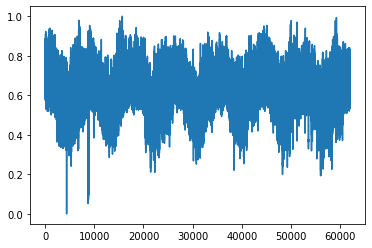

In [ ]:
plt.plot(historico["Temperatura"])

In [ ]:
base = historico.values
base

In [ ]:
diasAnteriores = 30*24

In [ ]:
carga = []
temp = []
previsores = []
valorReal = []
batch = []

for i in range(diasAnteriores,len(base)):
    carga = base[(i - diasAnteriores):i,5]
    temp = base[(i+1 - diasAnteriores):i+1,4]

    batch = np.column_stack((carga,temp))

    previsores.append(batch)    
    valorReal.append(base[i, 5])

previsores, valorReal = np.array(previsores), np.array(valorReal)
print(previsores)
print(previsores.shape)
valorReal

In [ ]:
def createModel():
    model = Sequential()

    model.add(LSTM(units=100, return_sequences = True,input_shape = (previsores.shape[1],2)))
    model.add(Dropout(0.3))

    # model.add(LSTM(units = 50, return_sequences = True))
    # model.add(Dropout(0.3))

    # model.add(LSTM(units = 50, return_sequences = True))
    # model.add(Dropout(0.3))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.3))

    model.add(Dense(units = 1, activation= "sigmoid"))



    model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mean_absolute_error"])

    es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 10, verbose = 1)
    rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
    mcp = ModelCheckpoint(filepath=f"pesos-{hoje}.h5", monitor = "loss", save_best_only = True, verbose=1)

    return model

In [ ]:
with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = createModel()
model.summary()

In [ ]:
model.fit(previsores, valorReal, epochs = 100, batch_size = 32, callbacks=[es,rlr,mcp])

In [ ]:
model = keras.models.load_model('/content/pesos-2021-02-02.h5')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 720, 100)          41200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 720, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 71,451
Trainable params: 71,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
testeDIR = "/content/drive/MyDrive/TG/TESTE" 

In [ ]:
historicoCargaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-01-31_CARGAHIST.csv'),sep=";",decimal=",")
historicoTemperaturaTeste = pd.read_csv(os.path.join(testeDIR,'SECO_2021-01-31_TEMPHIST.csv'),sep=";",decimal=",")

In [ ]:
historicoTeste = historicoCargaTeste.merge(historicoTemperaturaTeste)
historicoTeste = historicoTeste.drop(["Min"], axis = 1 )
valorRealTeste = historicoTeste.iloc[:, 4].values
valorRealTeste

Y_teste = []

for i in range(1,len(valorRealTeste)):
    Y_teste.append(valorRealTeste[i])

Y_teste = np.array(Y_teste)
Y_teste.shape

In [ ]:
Y_teste

array([31475.9, 30848.3, 29885.6, ..., 47910.1, 46934.1, 45655.1])

In [ ]:
historicoTeste[["Carga"]] = normalizadorCarga.fit_transform(historicoTeste[["Carga"]])
historicoTeste[["Temperatura"]] = normalizadorTemp.fit_transform(historicoTeste[["Temperatura"]])

In [ ]:
historicoTeste

,Ano,Mes,Dia,Hora,Carga,Temperatura
0,2014,1,1,1,0.329023,0.623677
1,2014,1,1,2,0.322514,0.619916
2,2014,1,1,3,0.302616,0.598464
3,2014,1,1,4,0.272095,0.598464
4,2014,1,1,5,0.249004,0.595340
...,...,...,...,...,...,...
62082,2021,1,30,19,0.737879,0.768265
62083,2021,1,30,20,0.848223,0.732182
62084,2021,1,30,21,0.843546,0.687396
62085,2021,1,30,22,0.812603,0.656636


In [ ]:
entradas = historicoTeste.values
entradas.shape

(62087, 6)

In [ ]:
X_teste = []

for i in range(len(entradas) - diasAnteriores,len(entradas)):
    cargaTeste = entradas[(i - diasAnteriores):i,5]
    tempTeste = entradas[(i+1 - diasAnteriores):i+1,4]
    
    batchTeste = np.column_stack((cargaTeste,tempTeste))

    X_teste.append(batchTeste)
    
X_teste = np.array(X_teste)
X_teste.shape

(720, 720, 2)

In [ ]:
previsoes = model.predict(X_teste)

In [ ]:
previsoes = normalizadorCarga.inverse_transform(previsoes)

In [ ]:
previsoes

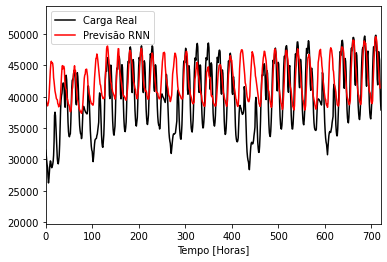

In [ ]:
axes = plt.gca()
axes.set_xlim([0,720])
plt.plot(Y_teste[:], color = "black", label = "Carga Real")
plt.plot(previsoes[:], color = "red", label = "Previsão RNN")
plt.xlabel("Tempo [Horas]")
plt.ylabel("")
plt.legend()
plt.show()